# CIS680: Project 2: YOLO
### Due:
* Part (a) Sept. 30 at 11:59 p.m.
* Part (b) Oct. 7 at 11:59 p.m.

### Instructions:
* Part (a) consists of parts 1-4, and is due on September 30 at 11:59 p.m. EDT.
* Part (b) consists of part 5-8 and is due on October 7 at 11:59 p.m. EDT
* This is a group assignment with one submission per group. It is expected that each member of the group will contribute to solving each question. Be sure to specify your teammates when you submit to Gradescope! Collaborating with other groups is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python.
* You may include any code used in previous projects.

## Introduction
Object detection is a fundamental task in computer vision. The problem of object recognition essentially consists of first localizing the object and then classifying it with a semantic label. In recent deep learning based methods, YOLO is an extremely fast real time multi object detection algorithm.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_1.png"/></div>
<center>Figure 1: This is a demo of what object detection does. The color indicates different semantic class.</center>  
  
In this project, we provide 10K street scene images with correponding labels as training data. The image dimension is $128 \times 128 \times 3$, and the labels include the semantic class and the bounding box corresponding to each object in the image. Note that a small portion of these ground-truth labels are not a little bit noisy and the quantity of the training set is not very large, so we do not expect you to learn a super robust object detector.

## Data Preprocessing
For this section, you will need to write code to preprocess the ground truth labels for the YOLO algorithm. The
labels are provided in the "label" folder. The format of the labels are (class, $x_1$, $y_1$, $x_2$, $y_2$), where $x_1$, $y_1$ are the top left corner of the bounding box and $x_2$, $y_2$ are the bottom right corner of the bounding box.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_2.png"/></div>
<center>Figure 2: This figure demonstrates the format of ground-truth labels that YOLO algorithm requires.</center>  
  
For each image, you are required to convert the provided labels into the $8 \times 8 \times 8$ ground truth matrix, which has the same dimension as the output of YOLO detection network. The instructions of this conversion is as follows:
* We consider a $16 \times 16$ image patch as a grid cell and thus divide the full image into $8 \times 8$ patches in the 2D spatial dimension. In the output activation space, one grid cell represents one 16x16 image patch with corresponding aligned locations.
* For simplified YOLO, we only use one anchor box, where we assume the anchor size is the same as the grid cell size. If the center of an object falls into a grid cell, that grid cell is responsible for detecting that object. This means that there is only one anchor for each object instance.
* For each anchor, there are 8 channels, which encode Pr(Objectness), $x$, $y$, $w$, $h$, P(class=pedestrian),  P(class=traffic light), and P(class=car).
* The Pr(Objectness) is the probability of whether this anchor is an object or background. When assigning the ground-truth for this value, "1" indicates object and "0" indicates background.
* The channels 2-5, $x$, $y$ coordinates represent the center of the box relative to the bounds of the grid cell; $w$, $h$ is relative to the image width and height.
* In channels 6-8, you need to convert the ground truth semantic label of each object into one-hot coding for each anchor boxes.
* Note that if the anchor box does not have any object (Pr=0), you donâ€™t need to assign any values to channels 2-8, since we will not use them during training.
* The dimensions are ordered (channels, x, y).

## Model Architecture
You are required to implement the model architecture using the following parameters. This model takes input with dimension of $128 \times 128 \times 3$ and outputs an activation with dimension of $8 \times 8 \times 8$.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_3.png"/></div>
<center>Figure 3: This figure demonstrates how to compute IoU.</center>

| Layer | Hyperparameters |
| :-: | :-: |
| conv1 | Kernel size $= 4 \times 4 \times 32$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv2 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv3 | Kernel size $= 4 \times 4 \times 128$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv4 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv5 | Kernel size $= 4 \times 4 \times 512$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv6 | Kernel size $= 4 \times 4 \times 1024$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv7 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv8 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv9 | Kernel size $= 3 \times 3 \times 8$, stride $=1$, pad $=1$. |


## Training Details
During training, the localization and classification errors are optimized jointly. The loss function is shown
as below.  $i$ indicates number of grid cells and $j$ indicates number of anchor boxes at each grid cell. In our
case, there is only one anchor box at each grid cell and $B = 1$.

$$ \text{Loss} = 
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(x_i - \hat{x}_i\right)}^2 + {\left(y_i - \hat{y}_i\right)}^2\right]} + 
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(\sqrt{w_i} - \sqrt{\hat{w}_i}\right)}^2 + {\left(\sqrt{h_i} - \sqrt{\hat{h}_i}\right)}^2\right]} + 
{\sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left(C_i - \hat{C}_i\right)} + 
{\lambda_\text{no obj} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{no obj} \left(C_i - \hat{C}_i\right)} + 
{\sum_{i=0}^{S^2} \mathbb{1}_{ij}^\text{obj} \sum_{c\, \in\, \text{classes}} \left(p_i(c) - \hat{p}_i(c)\right)}$$

* In our case there is only one anchor box at each grid, hence $B = 1$.
* $S^2 =$ total number of grid cells.
* $\mathbb{1}_{ij}^\text{obj} = 1$ if an object appears in grid cell $i$ and 0 otherwise.
* $\mathbb{1}_{ij}^\text{no obj}$ is the compliment of $\mathbb{1}_{ij}^\text{obj}$.
* $\hat{C}_i =$ Box confidence score $=$ Pr(box contains object) $\times$ IoU
* IoU $=$ Intersection over union between the predicted and the ground truth.
* $\hat{p}_i(c) =$ conditional class probability of class $c$ in cell $i$.

$\lambda_\text{coord}$ and and $\lambda_\text{no obj}$ are two hyperparameters for coordinate predictions and non-objectness classification. We set $\lambda_\text{coord} = 5$ and and $\lambda_\text{no obj} = 0.5$.

Each grid cell predicts 1 bounding box, confidence score for those boxes and class conditional probabilities.

The confidence Score reflects the degree of confidence that the box contains an object and how accurate the box is. If no object exists in the cell then the confidence score should be 0 else the confidence score should be equal to the IOU between the predicted box and the ground truth box.

During training, you can set learning rate of 10e-3 using Adam optimizer with default beta 1 and beta 2. You are encourage to adaptively adjust learning rate during training to see if the model will converge better. You should also visualize the loss over training iterations. You will need to decide at the iteration to stop training based on the loss visualization. (At least 20 epochs of training is required.)

## Post-Processing
During inference, the network is going to predict lots of overlapping redundant bounding boxes. To eliminate the redundant boxes, there are basically two steps:

1. Get rid of predicted boxes with low objectness probability (Pr $< 0.6$).
2. For each class, calculate the IoU for all the bounding boxes and cluster boxes with IoU > 0.5 as a group. For each group, find the one with highest Pr and suppress the other boxes. This is referred as non-max suppression.

To evaluate the performance of your YOLO implementation, compute the mean Average Precision (mAP) of inference. Predicted bounding boxes are a match with ground truth bounding boxes if they share the same label and have an IoU with the ground truth bounding box of greater than 0.5. These matches can be used to calculate a precision/recall curve for each class. The Average Precision for a class is the area under this curve. The mean of these Average Precision values over all the classes in inference gives the mean Average Precision of your network.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_4.png"/></div>
<center>Figure 4: This figure demonstrates post-process of how to get rid of redundant bounding box.</center>

## Initialization

In [ ]:

if 'google.colab' in str(get_ipython()):
    # Colab specific setup
    assignment_path = '/content/gdrive/My Drive/CIS680_2021/HW2/'
    
    # Mount your drive
    from google.colab import drive
    drive.mount("/content/gdrive")
    
    # Setup assignment folder and switch
    import os
    os.makedirs(assignment_path, exist_ok=True)
    os.chdir(assignment_path)
    
    # Only download files once
    if not os.path.isdir('tests'):
        !gdown --id 1QxzpuZoca68S-ZCfdqyWph7a-tfwa1az
        !unzip -u hw2_additional_files.zip && rm hw2_additional_files.zip
        
    !pip install otter-grader pytorch_lightning &> /dev/null
    
notebook_name = 'cis680_hw2.ipynb'
import otter
grader = otter.Notebook(notebook_name)
grader._colab = False

Mounted at /content/gdrive


## Code

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
seed = 17
torch.manual_seed(seed);

In [ ]:
# Use this function to import the provided data files
def load_data(file_name):
    return np.load(file_name, allow_pickle=True, encoding='latin1')['arr_0']

images = load_data('images.npz')
raw_labels = load_data('labels.npz')

In [ ]:
# This function should compute the 8X8X8 label from the raw labels for the corresponding image.
def process_labels(raw_labels):
    labels = np.zeros((8,8,8))
    raw_label = raw_labels[0]

    cell_lower_bounds = np.arange(0, 128, 16)
    cell_upper_bounds = cell_lower_bounds + 16
    cell_dim = 16

    #create grid...
    #The top left corner of the grid contains the x values of 0-16 and the y values of 0-16
    x1 = raw_label[:,1] #top left corner of the bounding box
    y1 = raw_label[:,2]
    x2 = raw_label[:,3] #bottom right corner of the bounding box
    y2 = raw_label[:,4]

    box_width = x2 - x1
    box_height = y2 - y1

    rel_width = box_width / 128
    rel_height = box_height / 128

    rel_width = np.expand_dims(rel_width, axis=1)
    rel_height = np.expand_dims(rel_height, axis=1)

    box_center_x = (x1 + x2)/2
    box_center_y = (y1 + y2)/2

    x_coor = np.floor(box_center_x/16).astype(np.int32)
    y_coor = np.floor(box_center_y/16).astype(np.int32)
    center_x_norm = (box_center_x-cell_lower_bounds[x_coor])/cell_dim
    center_y_norm = (box_center_y-cell_lower_bounds[y_coor])/cell_dim
    center_x_norm = np.expand_dims(center_x_norm, axis=1)
    center_y_norm = np.expand_dims(center_y_norm, axis=1)

    classes = raw_label[:,0].astype(np.int32)
    onehot = np.zeros((len(classes), 3))
    onehot[np.arange(len(classes)), classes]=1
    ones = np.ones((len(classes), 1))
            
    labels[x_coor, y_coor,:] = np.concatenate([ones, center_x_norm, center_y_norm, rel_width, rel_height, onehot], axis=1)
    labels = np.transpose(labels, (2, 0, 1))
    labels = labels[np.newaxis,:]

    
    #raw labels are 1x5 (class, x1, y1, x2, y2)
    #An input image is 128x128x3 
    #We want to create a 8x8 grid where each cell represents a 16x16 image patch
    #Our classification is over Pedestrian, Traffic Light, Car 
    #Each grid cell should contain: (Pr(object), x, y, w, h, P(Pedestrian), P(traffic light), P(car))

    #we should return an 8x8x8 ground truth matrix (channels, x, y)
    return labels

def process_all_labels(raw_labels):
    labels = np.zeros((len(raw_labels), 8, 8, 8))
    for i in range(len(raw_labels)):
      labels[i,:,:,:] = process_labels(raw_labels[i, np.newaxis])
    return labels

In [ ]:
# This function should perform the inverse operation of process_labels().
def reconstruct_raw_labels(labels, img_dim=128):
    label = labels[0]
    idx_x, idx_y = np.nonzero(label[0,:,:])
    cell_lower_bounds = np.arange(0, img_dim, 16)
    cell_dim = 16
    detected_objects = np.transpose(label[:,idx_x, idx_y])
    classes = np.argmax(detected_objects[:,5:], axis=1)
    center_x_norm = detected_objects[:,1]
    center_y_norm = detected_objects[:,2]
    center_x = cell_dim*center_x_norm+cell_lower_bounds[idx_x]
    center_y = cell_dim*center_y_norm+cell_lower_bounds[idx_y]
    w = detected_objects[:,3]*img_dim
    h = detected_objects[:,4]*img_dim
    x_min = center_x-(w / 2)
    x_max = center_x+(w / 2)
    y_min = center_y-(h / 2)
    y_max = center_y+(h / 2)
    box_attrib = [classes, x_min, y_min, x_max, y_max]
    for i in range(len(box_attrib)):
      box_attrib[i] = np.expand_dims(box_attrib[i], axis=1)
    raw_labels = np.concatenate(box_attrib, axis=1)
    return raw_labels[np.newaxis,:]

def reconstruct_prediction(prediction, img_dim=128):
    idx_x, idx_y = np.nonzero(prediction[0,:,:])
    cell_lower_bounds = np.arange(0, img_dim, 16)
    cell_dim = 16
    detected_objects = np.transpose(prediction[:,idx_x, idx_y])
    classes = np.argmax(detected_objects[:,5:], axis=1)
    conf = detected_objects[:,0]
    center_x_norm = detected_objects[:,1]
    center_y_norm = detected_objects[:,2]
    center_x = cell_dim*center_x_norm+cell_lower_bounds[idx_x]
    center_y = cell_dim*center_y_norm+cell_lower_bounds[idx_y]
    w = detected_objects[:,3]*img_dim
    h = detected_objects[:,4]*img_dim
    x_min = center_x-(w / 2)
    x_max = center_x+(w / 2)
    y_min = center_y-(h / 2)
    y_max = center_y+(h / 2)
    box_attrib = [conf, classes, x_min, y_min, x_max, y_max]
    for i in range(len(box_attrib)):
      box_attrib[i] = np.expand_dims(box_attrib[i], axis=1)
    raw_preds = np.concatenate(box_attrib, axis=1)
    return raw_preds

def reconstruct_all_predictions(predictions, img_dim=128):
    reconstructed = []
    for prediction in predictions:
      reconstructed.append(reconstruct_prediction(prediction))
    reconstructed = np.array(reconstructed, dtype=object)
    return reconstructed

def reconstruct_all_targets(tgts):
    reconstructed = []
    for lbl in tgts:
      lbl = np.expand_dims(lbl, 0)
      reconstructed.append(reconstruct_raw_labels(lbl)[0])
    reconstructed = np.array(reconstructed, dtype=object)
    return reconstructed

In [ ]:
def yolo_loss(output, target):
  batch_size = output.size(0)
  lambda_coord = 5
  lambda_noobj = 0.5
  det_mask = target[:,0,:,:]
  no_det_mask = torch.logical_not(det_mask)
  pred_x, pred_y, pred_w, pred_h = output[:,1,:,:], output[:,2,:,:], output[:,3,:,:], output[:,4,:,:]
  true_x, true_y, true_w, true_h = target[:,1,:,:], target[:,2,:,:], target[:,3,:,:], target[:,4,:,:]
  xy_loss = lambda_coord*((det_mask*((true_x-pred_x)**2+(true_y-pred_y)**2)).sum(dim=(1,2)))
  wh_loss = lambda_coord*((det_mask*((torch.sqrt(true_w)-torch.sqrt(pred_w))**2+(torch.sqrt(true_h)-torch.sqrt(pred_h))**2)).sum(dim=(1,2)))
  pred_class_probs1, pred_class_probs2, pred_class_probs3 = output[:,5,:,:], output[:,6,:,:], output[:,7,:,:]
  true_class_probs1, true_class_probs2, true_class_probs3 = target[:,5,:,:], target[:,6,:,:], target[:,7,:,:]
  class_loss = (det_mask*((true_class_probs1-pred_class_probs1)**2+(true_class_probs2-pred_class_probs2)**2+(true_class_probs3-pred_class_probs3)**2)).sum(dim=(1,2))
  grid_y = torch.arange(0, 128, 16).unsqueeze(0).unsqueeze(0).repeat(batch_size, 8, 1).to(output.device)
  grid_x = torch.transpose(grid_y, 1, 2).to(output.device)
  pred_x, true_x = pred_x*16+grid_x, true_x*16+grid_x
  pred_y, true_y = pred_y*16+grid_y, true_y*16+grid_y
  pred_w, true_w = pred_w * 128, true_w*128
  pred_h, true_h = pred_h * 128, true_h*128
  pred_x_min, pred_x_max, pred_y_min, pred_y_max = pred_x-pred_w/2, pred_x+pred_w/2, pred_y-pred_h/2, pred_y+pred_h/2
  true_x_min, true_x_max, true_y_min, true_y_max = true_x-true_w/2, true_x+true_w/2, true_y-true_h/2, true_y+true_h/2
  intersect_x_min, intersect_x_max = torch.maximum(pred_x_min, true_x_min), torch.minimum(pred_x_max, true_x_max)
  intersect_y_min, intersect_y_max = torch.maximum(pred_y_min, true_y_min), torch.minimum(pred_y_max, true_y_max)
  intersect = (intersect_x_max - intersect_x_min) * (intersect_y_max - intersect_y_min)
  valid_intersect_mask = torch.logical_and(intersect_x_min <= intersect_x_max, intersect_y_min <= intersect_y_max)
  intersect = intersect * valid_intersect_mask
  pred_area = pred_w*pred_h
  true_area = true_w*true_h
  union = pred_area + true_area - intersect
  iou = intersect / union
  invalid_iou_mask = union == 0
  iou[invalid_iou_mask] = 0
  chat = iou*det_mask
  c = output[:,0,:,:]
  conf_loss_obj = (det_mask*(c-chat)**2).sum(dim=(1,2))
  conf_loss_noobj = (no_det_mask*(c-chat)**2).sum(dim=(1,2))
  conf_loss = conf_loss_obj + lambda_noobj*conf_loss_noobj
  loss = xy_loss + wh_loss + class_loss + conf_loss
  return loss.mean()

In [ ]:
class YOLO(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        self.transposed_conv7 = nn.ConvTranspose2d(1024, 256, kernel_size=4, stride=2, padding=1)

        self.bn7 = nn.BatchNorm2d(256)
        self.transposed_conv8 = nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1)
        self.bn8 = nn.BatchNorm2d(64)
        self.conv9 = nn.Conv2d(64, 8, kernel_size=3, stride=1, padding=1)


        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.train_losses = []
        self.val_losses = []
        self.train_map = []
        self.val_map = []
        self.train_aps0 = []
        self.train_aps1 = []
        self.train_aps2 = []
        self.val_aps0 = []
        self.val_aps1 = []
        self.val_aps2 = []

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.relu(self.bn3(self.conv3(out)))
        out = self.relu(self.bn4(self.conv4(out)))
        out = self.relu(self.bn5(self.conv5(out)))
        out = self.relu(self.bn6(self.conv6(out)))
        out = self.relu(self.bn7(self.transposed_conv7(out)))
        out = self.relu(self.bn8(self.transposed_conv8(out)))
        out = self.sigmoid(self.conv9(out))
        return out

    def training_step(self, batch, batch_idx):
        img, target = batch
        output = self.forward(img)
        output_transformed = torch.transpose(output, 2, 3)
        loss = yolo_loss(output_transformed, target)
        self.log("train_loss", loss, prog_bar=True)
        
        return {"loss": loss, "preds": output_transformed.detach(), "tgts": target.detach()}
    
    def training_epoch_end(self, outputs):
        self.train_losses.append(torch.tensor([output["loss"] for output in outputs]).mean().item())
        train_preds = torch.cat([output["preds"] for output in outputs]).cpu().numpy()
        train_tgts = torch.cat([output["tgts"] for output in outputs]).cpu().numpy()
        train_preds = reconstruct_all_predictions(train_preds)
        train_tgts = reconstruct_all_targets(train_tgts)

        train_preds = [non_max_suppression(low_confidence_suppression(p)) for p in train_preds]
        train_preds = np.array(train_preds, dtype=object)

        avg = mean_average_precision(train_preds, train_tgts)
        self.train_aps0.append(average_precision(train_preds, train_tgts, 0))
        self.train_aps1.append(average_precision(train_preds, train_tgts, 1))
        self.train_aps2.append(average_precision(train_preds, train_tgts, 2))
        self.train_map.append(avg)

        if self.current_epoch == 99:
          self.train_recall0, self.train_precision0 = precision_recall_curve(train_preds, train_tgts, 0)
          self.train_recall1, self.train_precision1 = precision_recall_curve(train_preds, train_tgts, 1)
          self.train_recall2, self.train_precision2 = precision_recall_curve(train_preds, train_tgts, 2)
          self.train_ap0 = self.train_aps0[-1]
          self.train_ap1 = self.train_aps1[-1]
          self.train_ap2 = self.train_aps2[-1]
          self.train_final_map = avg
        
    def validation_step(self, batch, batch_idx):
        img, target = batch
        output = self.forward(img)
        output_transformed = torch.transpose(output, 2, 3)
        loss = yolo_loss(output_transformed, target)
        self.log("val_loss", loss, prog_bar=True)
        return {"loss": loss, "preds": output_transformed, "tgts": target.detach()}
    
    def validation_epoch_end(self, outputs):
        self.val_losses.append(torch.tensor([output["loss"] for output in outputs]).mean().item())

        val_preds = torch.cat([output["preds"] for output in outputs]).cpu().numpy()
        val_tgts = torch.cat([output["tgts"] for output in outputs]).cpu().numpy()
        val_preds = reconstruct_all_predictions(val_preds)
        val_tgts = reconstruct_all_targets(val_tgts)

        val_preds = [non_max_suppression(low_confidence_suppression(p)) for p in val_preds]
        val_preds = np.array(val_preds, dtype=object)

        avg = mean_average_precision(val_preds, val_tgts)
        self.val_aps0.append(average_precision(val_preds, val_tgts, 0))
        self.val_aps1.append(average_precision(val_preds, val_tgts, 1))
        self.val_aps2.append(average_precision(val_preds, val_tgts, 2))
        self.val_map.append(avg)

        if self.current_epoch == 99:
          self.val_recall0, self.val_precision0 = precision_recall_curve(val_preds, val_tgts, 0)
          self.val_recall1, self.val_precision1 = precision_recall_curve(val_preds, val_tgts, 1)
          self.val_recall2, self.val_precision2 = precision_recall_curve(val_preds, val_tgts, 2)
          self.val_ap0 = self.val_aps0[-1]
          self.val_ap1 = self.val_aps1[-1]
          self.val_ap2 = self.val_aps2[-1]
          self.val_final_map = avg

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=0.001)
        sched = {"scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.1), "monitor": "val_loss"}
        return {"optimizer": opt, "lr_scheduler": sched}

In [ ]:
def low_confidence_suppression(prediction):
    preds_to_keep = prediction[:,0] >= 0.6
    return prediction[preds_to_keep,:]

def non_max_suppression(prediction):
    sorted_idx = np.argsort(prediction[:,0])
    sorted_idx = sorted_idx[::-1]
    sorted_prediction = prediction[sorted_idx,:]
    postprocessed_prediction = []
    remaining_prediction = sorted_prediction
    while remaining_prediction.shape[0] > 0:
      current = remaining_prediction[0,:]
      if remaining_prediction.shape[0] == 0:
        break
      remaining_prediction = remaining_prediction[1:,:]
      postprocessed_prediction.append(np.expand_dims(current, axis=0))
      current_class = current[1]
      intersect_x_min = np.maximum(current[2], remaining_prediction[:,2])
      intersect_y_min = np.maximum(current[3], remaining_prediction[:,3])
      intersect_x_max = np.minimum(current[4], remaining_prediction[:,4])
      intersect_y_max = np.minimum(current[5], remaining_prediction[:,5])
      intersect = (intersect_x_max - intersect_x_min) * (intersect_y_max - intersect_y_min)
      invalid_idx = np.logical_or(intersect_x_max < intersect_x_min, intersect_y_max < intersect_y_min)
      area = (remaining_prediction[:,4]-remaining_prediction[:,2]) * (remaining_prediction[:,5]-remaining_prediction[:,3])
      current_area = (current[4]-current[2]) * (current[5]-current[3])
      union = current_area + area - intersect
      iou = intersect / union
      iou[invalid_idx] = 0
      iou[union==0] = 0
      idx = np.logical_not(np.logical_and(iou > 0.5, remaining_prediction[:,1]==current_class))
      remaining_prediction = remaining_prediction[idx, :]
    
    if len(postprocessed_prediction) == 0:
      return np.zeros((0, 6))
  
    output = np.concatenate(postprocessed_prediction, axis=0)

    return output

In [ ]:
def precision_recall_curve(predictions, targets, target_class):
    # first filter class predictions
    filtered_predictions_list = []
    filtered_target_list = []
    for i in range(len(targets)):
      p = predictions[i]
      t = targets[i]
      filp = p[p[:,1]==target_class,:]
      filt = t[t[:,0]==target_class,:]
      if filt.shape[0] > 0:
        filtered_predictions_list.append(filp)
        filtered_target_list.append(filt)
    filtered_predictions = np.array(filtered_predictions_list, dtype=object)
    filtered_targets = np.array(filtered_target_list, dtype=object)
    all_preds = np.concatenate(filtered_predictions_list, axis=0)

    # match each ground truth to the highest confidence predicted box with IoU > 0.5
    matches = []
    for i in range(len(filtered_targets)):
      target = filtered_targets[i]
      prediction = filtered_predictions[i]
      for j in range(target.shape[0]):
        box = target[j,:]
        intersect_x_min = np.maximum(box[1], prediction[:,2])
        intersect_y_min = np.maximum(box[2], prediction[:,3])
        intersect_x_max = np.minimum(box[3], prediction[:,4])
        intersect_y_max = np.minimum(box[4], prediction[:,5])
        intersect = (intersect_x_max - intersect_x_min) * (intersect_y_max - intersect_y_min)
        invalid_idx = np.logical_or(intersect_x_max < intersect_x_min, intersect_y_max < intersect_y_min)
        area = (prediction[:,4]-prediction[:,2]) * (prediction[:,5]-prediction[:,3])
        box_area = (box[4]-box[2]) * (box[3]-box[1])
        union = box_area + area - intersect
        iou = intersect / union
        iou[invalid_idx] = 0
        iou[union==0] = 0
        iou_matches = prediction[iou > 0.5, :]
        if iou_matches.shape[0] == 0:
          iou_matches = np.zeros((1, 6))
          iou_matches[0,0] = -1
        elif iou_matches.shape[0] > 1:
          max_iou_idx = np.argmax(iou[iou > 0.5])
          iou_matches = np.expand_dims(iou_matches[max_iou_idx,:], axis=0)
        matches.append(iou_matches)

    if len(matches) == 0:
      return [np.nan], [np.nan]

    matches_flattened = np.concatenate(matches, axis=0)
    filtered_targets_flattened = np.concatenate(filtered_target_list, axis=0)
    valid_match_idx = matches_flattened[:,0] != -1
    total_ground_truth = filtered_targets_flattened.shape[0]
    matches_flattened = matches_flattened[valid_match_idx,:]
    filtered_predictions_flattened = matches_flattened

    if matches_flattened.shape[0] == 0:
      return [np.nan], [np.nan]

    # sort by confidence values across entire dataset
    sorted_idx = np.argsort(filtered_predictions_flattened[:,0])
    sorted_idx = sorted_idx[::-1]
    preds_sorted = filtered_predictions_flattened[sorted_idx,:]

    # initialize precision and recall
    max_recall = preds_sorted.shape[0] / total_ground_truth
    assert max_recall <= 1
    steps = 100
    recall = np.arange(0, max_recall, max_recall / steps)
    precision = np.zeros((len(recall)))
    precision[0] = 1

    for i in range(1, len(recall)):
      rec = recall[i]

      tp = np.floor(rec*total_ground_truth).astype(np.int32)
      if tp == 0:
        threshold = 1
      else:
        threshold = preds_sorted[tp-1,0]
      total_preds = np.sum(all_preds[:,0] >= threshold)
      if total_preds == 0:
        prec = 1
      else: 
        prec = tp / total_preds
      precision[i] = prec
    
    return recall, precision

def average_precision(predictions, targets, target_class):
    recall, precision = precision_recall_curve(predictions, targets, target_class)
    if np.any(np.isnan(precision)):
      return 0
    average_precision = np.sum((recall[1:]-recall[:-1])*precision[1:])
    return average_precision

def mean_average_precision(predictions, targets):
    classes = [1, 2, 3]
    aps = [average_precision(predictions, targets, target_class) for target_class in classes]
    mean_average_precision = np.mean(aps)
    return mean_average_precision, aps

## Instructions and Evaluation

This project is divided into the following parts:

1. Choose an image that has all three classes present (the image has a car, a person, and a traffic light.
  1. Show the chosen image with ground truth bounding boxes visualized. Use green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights. See Figure 1 as an example of what this visualization should look like. (3%)
  2. Convert the image labels to an 8x8x8 representation, and show each channel of the processed labels in the report. Label the visualization of each channel with the associated channel number and visualized value. Example: "Channel 1: Pr(Objectness)". (5%)
  3. To test your data preprocessing code, convert your 8x8x8 representation for this step back to the original input data and ensure that your image with recomputed bounding boxes looks the same as the input. Show this image with bounding box visualizations in your report. This test code for data preprocessing will also be needed in the inference step. (2%)

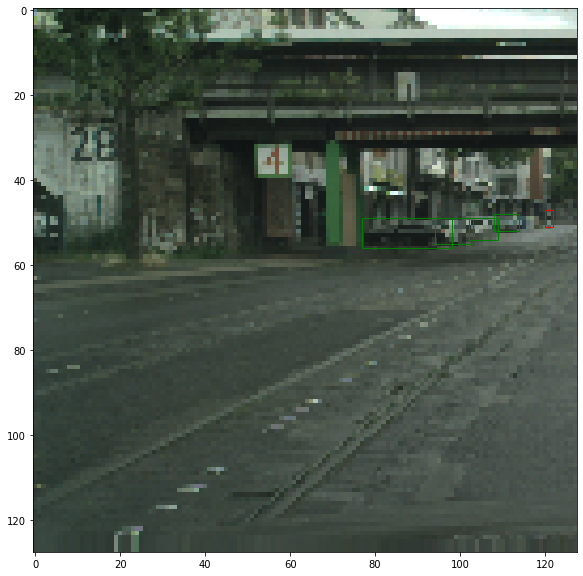

In [ ]:
# Show the chosen image with ground truth bounding boxes visualized.
from matplotlib.patches import Rectangle
img = images[0]
raw_label = raw_labels[0]
cmap = {0: 'r', 1: 'b', 2: 'g'}
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)
for i in range(len(raw_label)):
  w = raw_label[i,3]-raw_label[i,1]
  h = raw_label[i,4]-raw_label[i,2]
  col = cmap[raw_label[i,0]]
  rect = Rectangle((raw_label[i,1], raw_label[i,2]), w, h, edgecolor=col, facecolor=None, fill=False)
  ax.add_patch(rect)
plt.show()

<!-- BEGIN QUESTION -->



<Figure size 432x288 with 0 Axes>

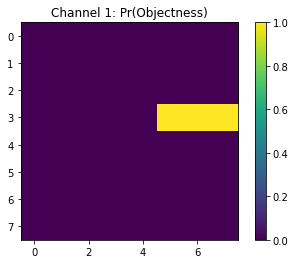

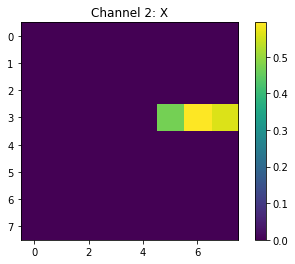

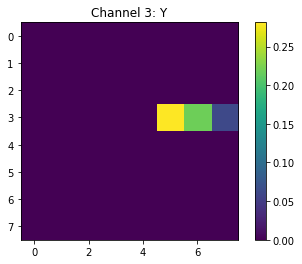

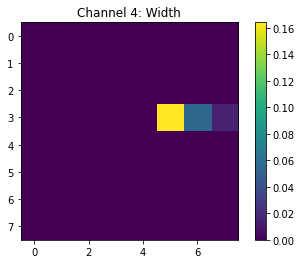

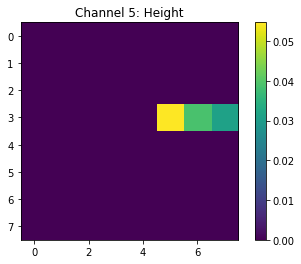

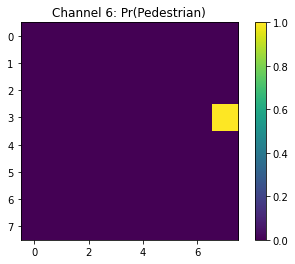

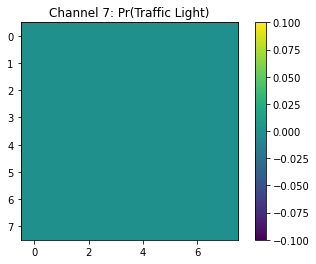

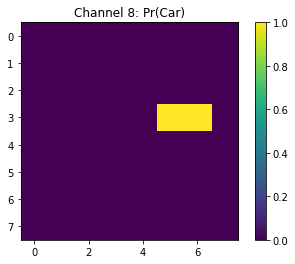

In [ ]:
# Visualize the 8x8x8 representation.
labels = process_all_labels(raw_labels)
label = labels[0]
label_correct = np.transpose(label, axes=(0, 2, 1))
channel_names = ['Channel 1: Pr(Objectness)', 'Channel 2: X', 'Channel 3: Y', 'Channel 4: Width', 'Channel 5: Height', 'Channel 6: Pr(Pedestrian)', 'Channel 7: Pr(Traffic Light)', 'Channel 8: Pr(Car)']
fig = plt.figure()
for i in range(8):
  plt.figure()
  plt.title(channel_names[i])
  plt.imshow(label_correct[i])
  plt.colorbar()
  plt.show()

In [ ]:
grader.check("q1b")

q1b results: All test cases passed!

<!-- END QUESTION -->



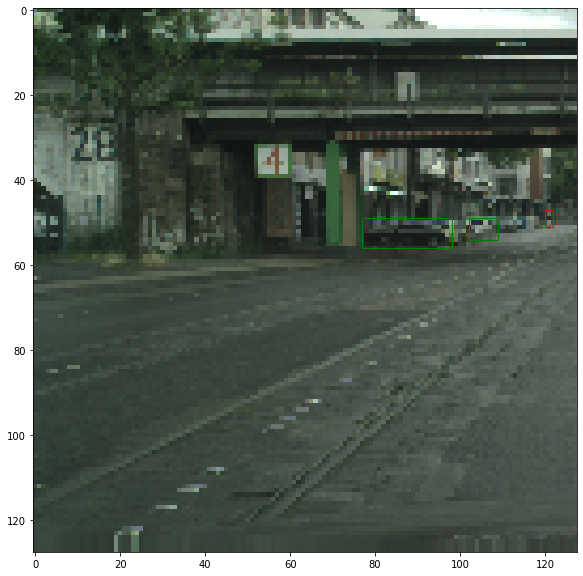

In [ ]:
# Convert back to the original representation (test cases below should pass).
label_input = label[np.newaxis,:]
reconstructed = reconstruct_raw_labels(label_input)[0]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)
for i in range(len(reconstructed)):
  w = reconstructed[i,3]-reconstructed[i,1]
  h = reconstructed[i,4]-reconstructed[i,2]
  col = cmap[reconstructed[i,0]]
  rect = Rectangle((reconstructed[i,1], reconstructed[i,2]), w, h, edgecolor=col, facecolor=None, fill=False)
  ax.add_patch(rect)
plt.show()

In [ ]:
grader.check("q1c")

q1c results: All test cases passed!

2. Implement the loss function. (3%)

In [ ]:
grader.check("q2")

q2 results: All test cases passed!

3. Make block diagram of requested architecture. Label the diagram with the parts of your code which implement each component. Explain any deviations you made from the described architecture. (15%)

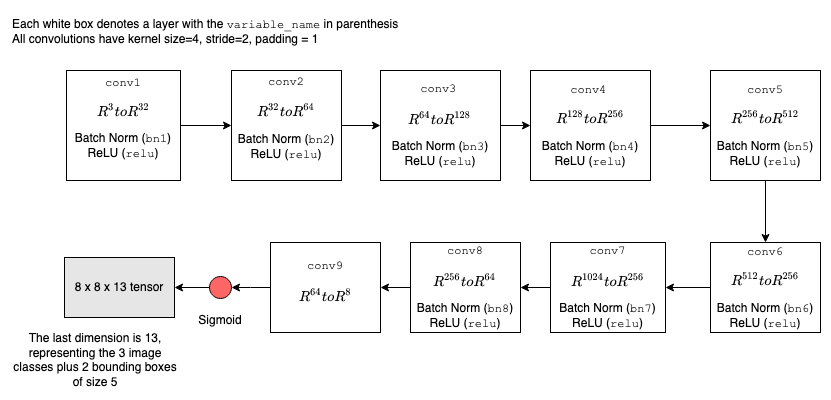



Design choices we made:

The model was initially very heavily overfitting/memorizing the training dataset, we used a training validation split of 80% to 20% of the provided dataset. Our initial plots demonstrated these results. To prevent the model from overfitting we tried a variety of methods including; learning rate scheduling to reduce the learning rate at the later stage of training, changing the kernel size of different layers, reducing the number of hidden layers and reducing the number of learned parameters. None of these methods served very well to make our model very robust so we returned to the initial model (we kept the learning rate scheduling though).

Furthermore, we decided the optimal epoch to stop at (the epoch where the validation loss stopped decreasing) was epoch 29, so we decided to train the model for 30 epochs (see plot 4 for loss visualization).




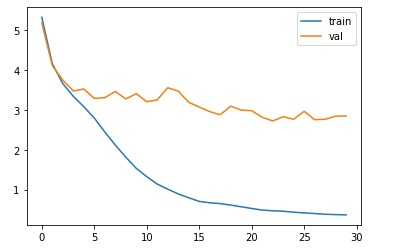

Graph above with learning rate scheduling.


Graph below with number of hidden layers reduced to 5, as well as kernel size changed to 3 and reduced number of parameters to learn.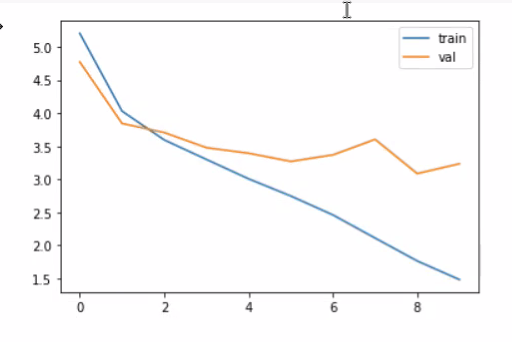

4. Show a plot of the loss over training for your model. (Raw Tensorboard output is not sufficient) (10%) 

In [ ]:
# Setup your training
import math
from torch.utils.data import TensorDataset, DataLoader

train_split = 0.8
idx = np.arange(len(images))
train_idx = np.random.choice(idx, math.floor(train_split*len(idx)), replace=False)
val_idx = [i for i in idx if i not in train_idx]

norm_images = np.transpose(images/255, axes=[0,3,1,2])
train_labels = torch.tensor(labels[train_idx]).float()
val_labels = torch.tensor(labels[val_idx]).float()

train_imgs = torch.tensor(norm_images[train_idx]).float()
val_imgs = torch.tensor(norm_images[val_idx]).float()

train_data = TensorDataset(train_imgs, train_labels)
val_data = TensorDataset(val_imgs, val_labels) 

train_loader = DataLoader(train_data, batch_size=32)
val_loader = DataLoader(val_data, batch_size=32)


In [ ]:
# Train your model
model = YOLO()

trainer = pl.Trainer(max_epochs=100, gpus=1)
trainer.fit(model, train_loader, val_loader)


## TRAINING_CODE
torch.save(model.state_dict(), 'yolo.pth')


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name             | Type            | Params
------------------------------------------------------
0  | conv1            | Conv2d          | 1.6 K 
1  | bn1              | BatchNorm2d     | 64    
2  | conv2            | Conv2d          | 32.8 K
3  | bn2              | BatchNorm2d     | 128   
4  | conv3            | Conv2d          | 131 K 
5  | bn3              | BatchNorm2d     | 256   
6  | conv4            | Conv2d          | 524 K 
7  | bn4              | BatchNorm2d     | 512   
8  | conv5            | Conv2d          | 2.1 M 
9  | bn5              | BatchNorm2d     | 1.0 K 
10 | conv6            | Conv2d          | 8.4 M 
11 | bn6              | BatchNorm2d     | 2.0 K 
12 | transposed_conv7 | ConvTranspose2d | 4.2 M 
13 | bn7              | BatchNorm2d     | 512   
14 | transposed_conv8 | ConvTranspose2d | 262 K 
15 | bn8 

Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

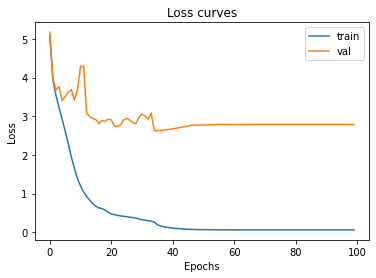

In [ ]:
# Plot the results
plt.figure()
epochs = np.arange(100)
plt.plot(epochs, model.train_losses)
plt.plot(epochs, model.val_losses[1:])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss curves')

plt.legend(['train', 'val']) 
plt.show()

optimal_epochs = 75

5. Show a plot of the mean Average Precision over training for your model. (10%)

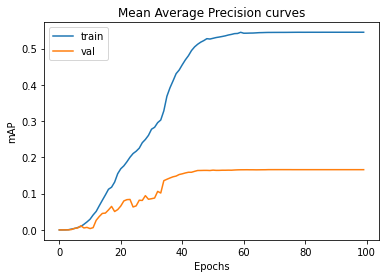

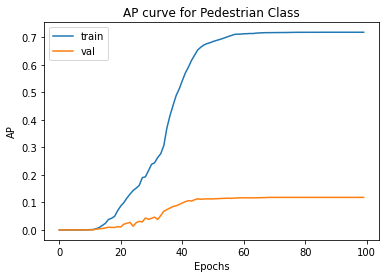

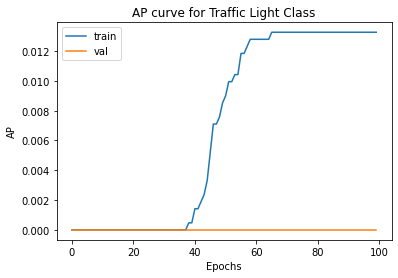

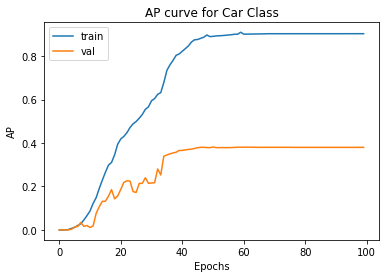

In [ ]:
plt.figure()
epochs = np.arange(100)
plt.plot(epochs, model.train_map)
plt.plot(epochs, model.val_map[1:])
plt.xlabel('Epochs')
plt.ylabel('mAP')
plt.title('Mean Average Precision curves')
plt.legend(['train', 'val']) 

plt.figure()
epochs = np.arange(100)
plt.plot(epochs, model.train_aps0)
plt.plot(epochs, model.val_aps0[1:])
plt.xlabel('Epochs')
plt.ylabel('AP')
plt.title('AP curve for Pedestrian Class')
plt.legend(['train', 'val']) 

plt.figure()
epochs = np.arange(100)
plt.plot(epochs, model.train_aps1)
plt.plot(epochs, model.val_aps1[1:])
plt.xlabel('Epochs')
plt.ylabel('AP')
plt.title('AP curve for Traffic Light Class')
plt.legend(['train', 'val']) 

plt.figure()
epochs = np.arange(100)
plt.plot(epochs, model.train_aps2)
plt.plot(epochs, model.val_aps2[1:])
plt.xlabel('Epochs')
plt.ylabel('AP')
plt.title('AP curve for Car Class')
plt.legend(['train', 'val']) 

plt.show()


Final Train mAP: 0.5450284217747473
Final Val mAP: 0.1661037929651842


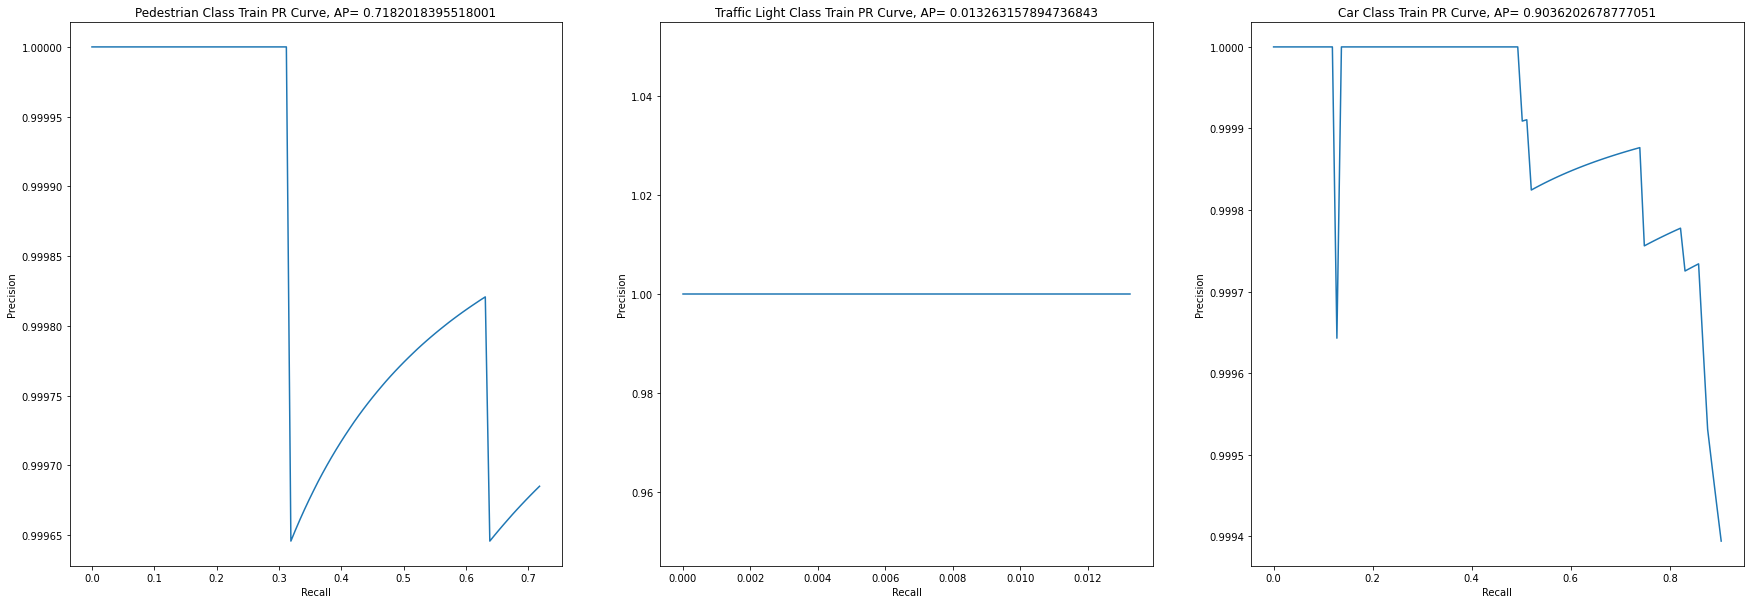

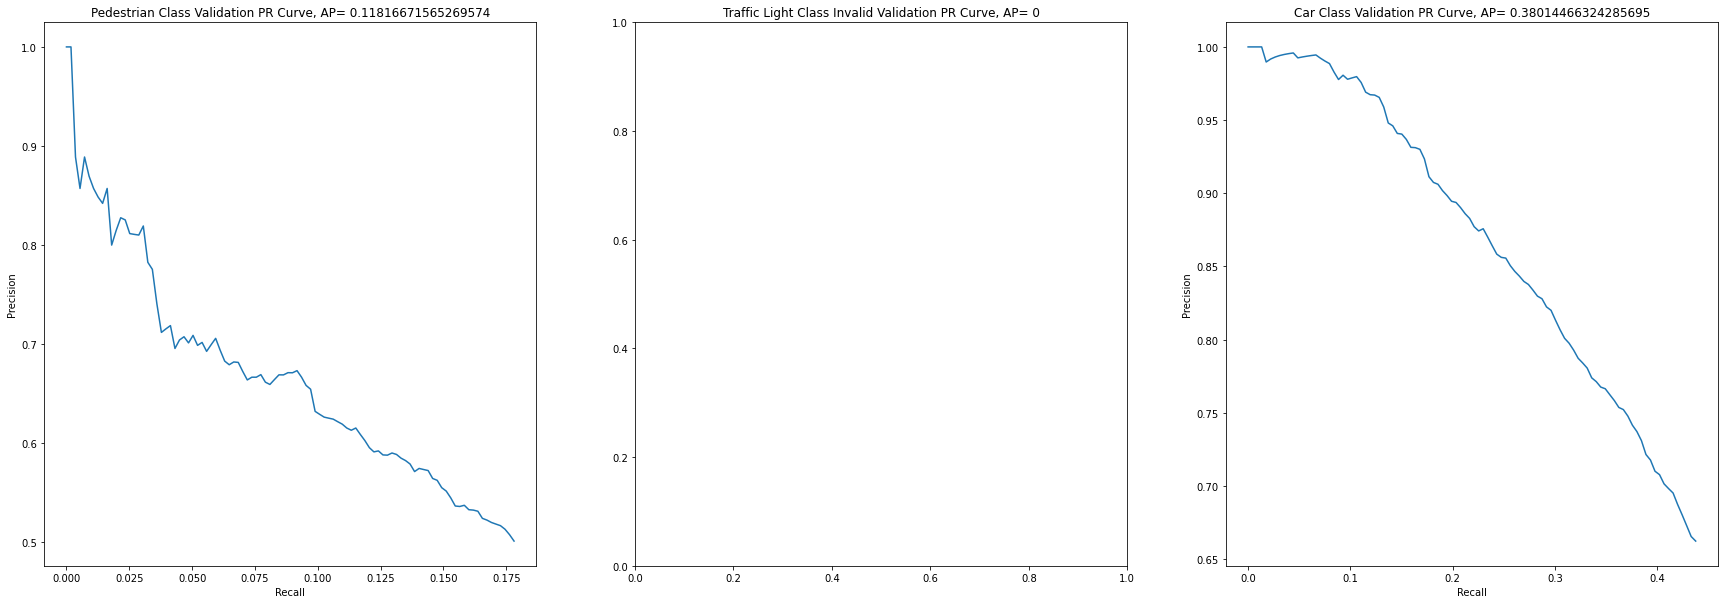

In [ ]:
print("Final Train mAP: " + str(model.train_final_map))
print("Final Val mAP: " + str(model.val_final_map))

def plot_pr_curve(p, r, ap, c, ax, train=True):
  mode = 'Train' if train else 'Validation'
  class_map = {0: 'Pedestrian', 1: 'Traffic Light', 2: 'Car'}
  if np.any(np.isnan(p)):
    ax.set_title(str(class_map[c]) + ' Class Invalid ' + str(mode) + ' PR Curve, AP= ' + str(ap))
  else:
    ax.set_title(str(class_map[c]) + ' Class ' + str(mode) + ' PR Curve, AP= ' + str(ap))
    ax.plot(r, p)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')

fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 3, 1)
plot_pr_curve(model.train_precision0, model.train_recall0, model.train_ap0, 0, ax)
ax = fig.add_subplot(1, 3, 2)
plot_pr_curve(model.train_precision1, model.train_recall1, model.train_ap1, 1, ax)
ax = fig.add_subplot(1, 3, 3)
plot_pr_curve(model.train_precision2, model.train_recall2, model.train_ap2, 2, ax)
plt.show()

fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 3, 1)
plot_pr_curve(model.val_precision0, model.val_recall0, model.val_ap0, 0, ax, train=False)
ax = fig.add_subplot(1, 3, 2)
plot_pr_curve(model.val_precision1, model.val_recall1, model.val_ap1, 1, ax, train=False)
ax = fig.add_subplot(1, 3, 3)
plot_pr_curve(model.val_precision2, model.val_recall2, model.val_ap2, 2, ax, train=False)
plt.show()


6. For one image in the inference step, show the predicted bounding boxes in the image before performing any elimination. Then, show the annotated image after the low probability bounding boxes are removed. Finally, show image after performing non-max suppression. Label each of these visualizations. See Figure 4 as an example of what this visualization should look like. (15%)

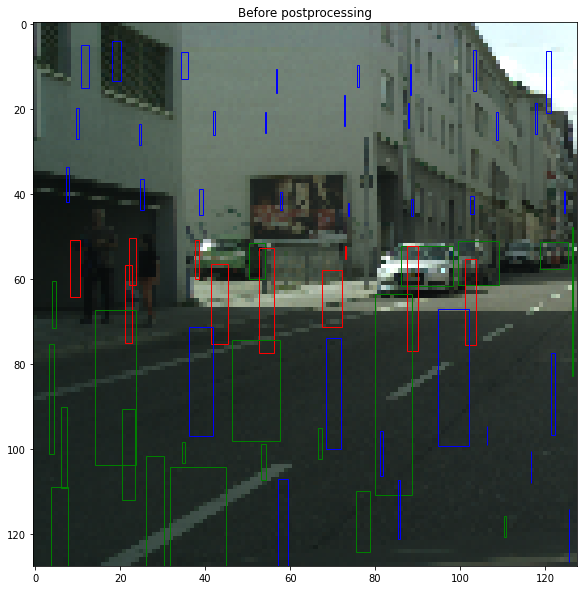

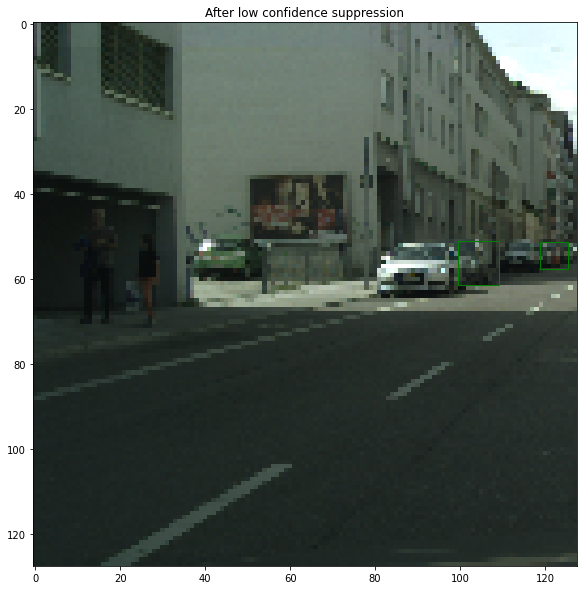

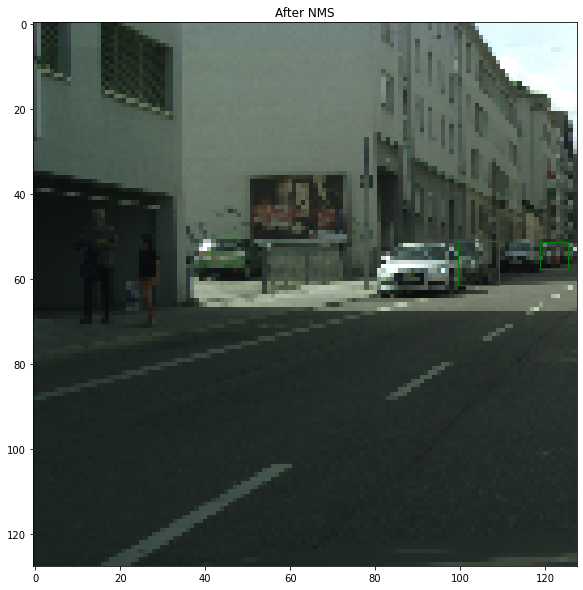

In [ ]:
img = val_imgs[2:3].to(device)
lab = val_labels[2:3].detach().numpy()
model = model.to(device)
orig_pred = model(img)
pred = torch.transpose(orig_pred, 2, 3)[0].cpu().detach().numpy()
reconstructed_pred = reconstruct_prediction(pred)
reconstructed_label = reconstruct_raw_labels(lab)[0]
postprocessed_pred1 = low_confidence_suppression(reconstructed_pred)
postprocessed_pred2 = non_max_suppression(postprocessed_pred1)

img = img[0].permute(1, 2, 0).cpu().detach().numpy()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
cmap = {0: 'r', 1: 'b', 2: 'g'}
ax.imshow(img)
ax.set_title('Before postprocessing')
for i in range(len(reconstructed_pred)):
  w = reconstructed_pred[i,4]-reconstructed_pred[i,2]
  h = reconstructed_pred[i,5]-reconstructed_pred[i,3]
  col = cmap[reconstructed_pred[i,1]]
  rect = Rectangle((reconstructed_pred[i,2], reconstructed_pred[i,3]), w, h, edgecolor=col, facecolor=None, fill=False)
  ax.add_patch(rect)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)
ax.set_title('After low confidence suppression')
for i in range(len(postprocessed_pred1)):
  w = postprocessed_pred1[i,4]-postprocessed_pred1[i,2]
  h = postprocessed_pred1[i,5]-postprocessed_pred1[i,3]
  col = cmap[postprocessed_pred1[i,1]]
  rect = Rectangle((postprocessed_pred1[i,2], postprocessed_pred1[i,3]), w, h, edgecolor=col, facecolor=None, fill=False)
  ax.add_patch(rect)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)
ax.set_title('After NMS')
for i in range(len(postprocessed_pred2)):
  w = postprocessed_pred2[i,4]-postprocessed_pred2[i,2]
  h = postprocessed_pred2[i,5]-postprocessed_pred2[i,3]
  col = cmap[postprocessed_pred2[i,1]]
  rect = Rectangle((postprocessed_pred2[i,2], postprocessed_pred2[i,3]), w, h, edgecolor=col, facecolor=None, fill=False)
  ax.add_patch(rect)
plt.show()

7. For one image in the inference step, show the bounding boxes visualized for each class with green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights as done in Figure 1. Show the precision/recall curves for each class in inference. Write down the achieved mean Average Precision for your inference stage. (17%)

mAP: 0.49499999999999994


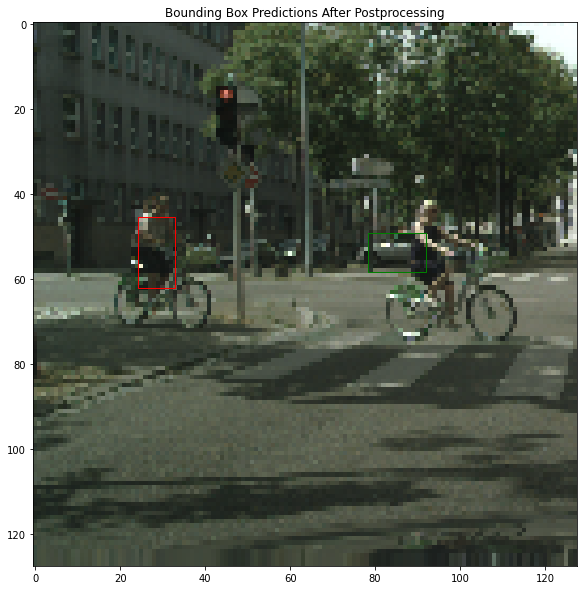

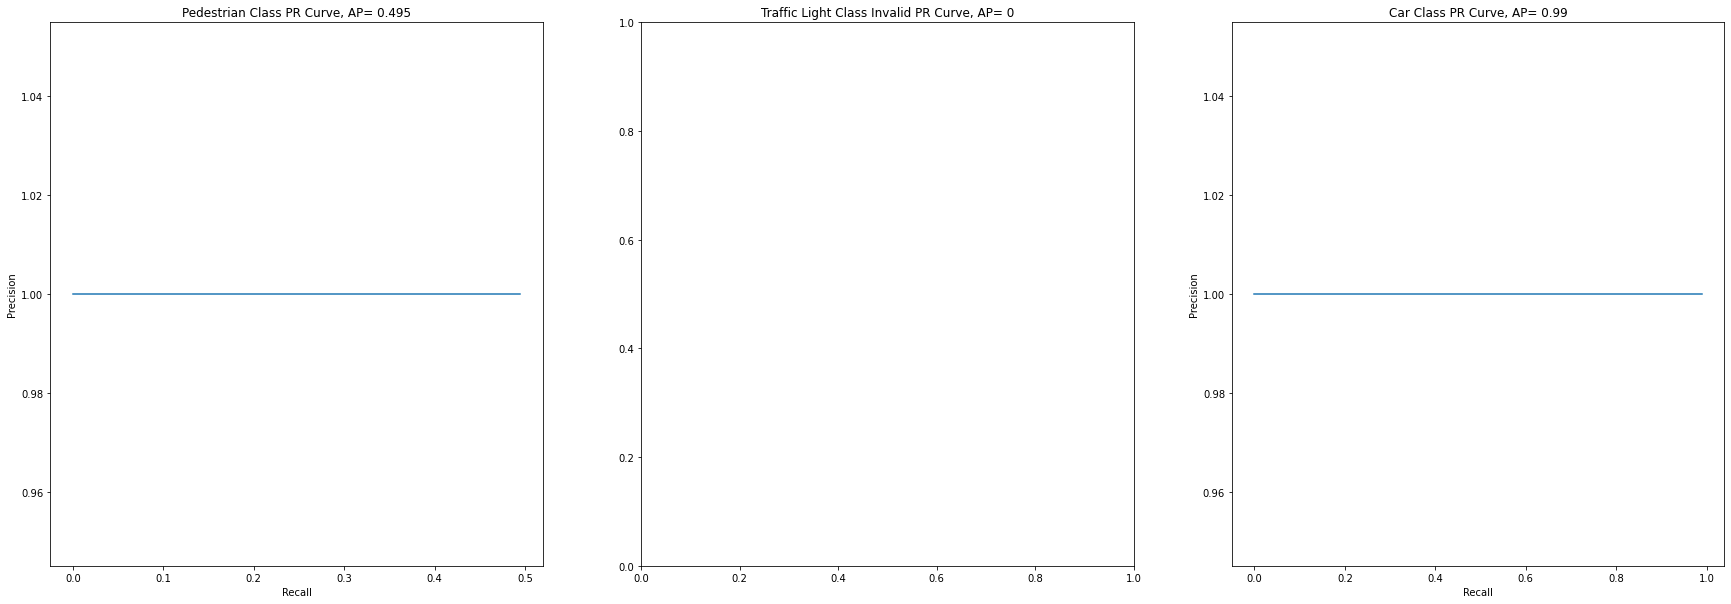

In [ ]:
img = torch.tensor(norm_images[9882]).unsqueeze(0).float().to(device)
lab = torch.tensor(labels[9882]).cpu().detach().numpy()
lab = np.expand_dims(lab, axis=0)
pred = model(img)
pred = torch.transpose(pred, 2, 3)[0].cpu().detach().numpy()
reconstructed_pred = reconstruct_prediction(pred)
reconstructed_label = reconstruct_raw_labels(lab)[0]
postprocessed_pred1 = low_confidence_suppression(reconstructed_pred)
postprocessed_pred2 = non_max_suppression(postprocessed_pred1)

img = img[0].permute(1, 2, 0).cpu().detach().numpy()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
cmap = {0: 'r', 1: 'b', 2: 'g'}
ax.imshow(img)
ax.set_title('Bounding Box Predictions After Postprocessing')
for i in range(len(postprocessed_pred2)):
  w = postprocessed_pred2[i,4]-postprocessed_pred2[i,2]
  h = postprocessed_pred2[i,5]-postprocessed_pred2[i,3]
  col = cmap[postprocessed_pred2[i,1]]
  rect = Rectangle((postprocessed_pred2[i,2], postprocessed_pred2[i,3]), w, h, edgecolor=col, facecolor=None, fill=False)
  ax.add_patch(rect)

preds = np.array([postprocessed_pred2], dtype=object)
targ = np.array([reconstructed_label], dtype=object)

recall0, precision0 = precision_recall_curve(preds, targ, 0)
recall1, precision1 = precision_recall_curve(preds, targ, 1)
recall2, precision2 = precision_recall_curve(preds, targ, 2)
ap0 = average_precision(preds, targ, 0)
ap1 = average_precision(preds, targ, 1)
ap2 = average_precision(preds, targ, 2)

map = mean_average_precision(preds, targ)
print("mAP: " + str(map))

def plot_pr_curve(p, r, ap, c, ax):
  class_map = {0: 'Pedestrian', 1: 'Traffic Light', 2: 'Car'}
  if np.any(np.isnan(p)):
    ax.set_title(str(class_map[c]) + ' Class Invalid PR Curve, AP= ' + str(ap))
  else:
    ax.set_title(str(class_map[c]) + ' Class PR Curve, AP= ' + str(ap))
    ax.plot(r, p)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')

fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 3, 1)
plot_pr_curve(precision0, recall0, ap0, 0, ax)
ax = fig.add_subplot(1, 3, 2)
plot_pr_curve(precision1, recall1, ap1, 1, ax)
ax = fig.add_subplot(1, 3, 3)
plot_pr_curve(precision2, recall2, ap2, 2, ax)
plt.show()

8. Explain any issues or challenges you had with your implementation. Explain the performance you achieved and any interesting observations you made while training your network. Discuss hypotheses for how you could improve the performance of your implementation further. (20%)

The main challenge with our implementation was that the network was overfitting, given the significantly lower training loss compared to the validation loss, and the significantly larger training mAP compared to the validation map. We tried many methods of addressing overfitting, including changing the network architecture to reduce the number of weights, early stopping, and learning rate scheduling, but these choices didn't seem to do much, so we concluded that overfitting was a difficult problem to address given the very small size of the dataset, especially compared to the size of the model which is pretty large. 

Another challenge was that imbalanced class labels in the training dataset lead to low prediction accuracy of traffic lights (since there are much fewer instances of traffic lights in the images compared to cars). Furthermore, we  found that certain classes (traffic lights and pedestrians in this dataset) took longer to learn because of the differences in class frequencies. Both these points are evidenced in the fact that our network starts reliably detecting different classes after a different number of epochs.

After training for 100 epochs, our network was able to reliably detect cars and pedestrians but was unable to generalize to the validation set to detect traffic lights. As you can see in the AP curves by class across training, the model has the highest training and validation AP for cars (the most frequent object class), followed by pedestrians. The training AP for traffic lights is small and the validation AP is 0. In the inference stage, we fed in an image with objects of all 3 classes and the model failed to predict any traffic lights. We believe that based on the quality of the provided data set and due to the relatively low number of traffic light instances, we would need to tailor our network to learn faster when exposed to the traffic light class, however this might lower its performance in the other classes. A better alternative would be to train the network on a larger dataset with more traffic light instances. We could also try changing the sampling process so that images with traffic lights are sampled more and images with many cars are sampled less during training. We could also modify the loss function so that different classes are weighted differently (a larger weight on the traffic light class might allow the model to learn to identify instances of traffic lights).

In terms of technical challenges, we struggled with manually calculating the precision-recall curve and preprocessing the raw labels into the label format used by the model (these were both tricky/lengthy algorithms to implement), but we were able to figure it out after much debugging. 


## Some Useful Online Materials

Original YOLO paper:  
https://arxiv.org/pdf/1506.02640.pdf

Intuitive Explanation:  
https://towardsdatascience.com/yolo-you-only-look-once-real-time-object-detection-explained-492dc9230006

YOLO Video Tutorial:  
https://www.youtube.com/watch?v=9s_FpMpdYW8&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=30

mean Average Precision:  
https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173

Intersection over Union:  
https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection

## Submission

Make sure you have run all cells in your notebook in order before you zip together your submission, so that all images/graphs appear in the output. 

For part (a), your submission should consist of this file and a pdf report. This report can simply be a pdf version of this document. Example conversion code below.

**Please save before exporting!**

In [ ]:
!sudo apt-get update &> /dev/null
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended &> /dev/null
!jupyter nbconvert --to pdf cis680_hw2.ipynb

[NbConvertApp] Converting notebook cis680_hw2.ipynb to pdf
[NbConvertApp] ERROR | Notebook JSON is invalid: Additional properties are not allowed (u'metadata' was unexpected)

Failed validating u'additionalProperties' in stream:

On instance[u'cells'][36][u'outputs'][0]:
{u'metadata': {u'tags': None},
 u'name': u'stderr',
 u'output_type': u'stream',
 u'text': u'GPU available: True, used: True\nTPU available: False, using: 0 TPU cores\nIPU available: False, using: 0 IPUs\nLOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]\n\n   | Name             | Type            | Params\n------------------------------------------------------\n0  | conv1            | Conv2d          | 1.6 K \n1  | bn1              | BatchNorm2d     | 64    \n2  | conv2            | Conv2d          | 32.8 K\n3  | bn2              | BatchNorm2d     | 128   \n4  | conv3            | Conv2d          | 131 K \n5  | bn3              | BatchNorm2d     | 256   \n6  | conv4            | Conv2d          | 524 K \n7  | bn4              |

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()